In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.6
Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!ls /content/drive/MyDrive/MNIST

t10k-images.idx3-ubyte.zip


In [5]:
!unzip /content/drive/MyDrive/MNIST/t10k-images.idx3-ubyte.zip -d /content/mnist_data


Archive:  /content/drive/MyDrive/MNIST/t10k-images.idx3-ubyte.zip
  inflating: /content/mnist_data/t10k-images.idx3-ubyte  


In [9]:
!cp /content/drive/MyDrive/MNIST/t10k-labels.idx1-ubyte /content/mnist_data

In [10]:
!ls /content/mnist_data

t10k-images.idx3-ubyte	t10k-labels.idx1-ubyte


LARGE CNN MODEL(9 LAYERS)

In [73]:
import os
import struct
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class MNIST_IDX_Dataset(Dataset):
    """
    Custom PyTorch Dataset class to handle MNIST data in the IDX file format.
    """
    def __init__(self, image_path, label_path):
        """
        Args:
            image_path (str): Path to the .idx3-ubyte image file.
            label_path (str): Path to the .idx1-ubyte label file.
        """
        self.images = self._read_image_file(image_path)
        self.labels = self._read_label_file(label_path)

    def _read_label_file(self, path):
        """Reads a .idx1-ubyte file and returns a tensor of labels."""
        with open(path, 'rb') as f:
            # Read header information
            # >: big-endian, I: unsigned int
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic != 2049:
                raise ValueError(f"Invalid magic number {magic} in label file {path}")

            # Read label data
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return torch.tensor(labels, dtype=torch.long)

    def _read_image_file(self, path):
        """Reads a .idx3-ubyte file and returns a tensor of images."""
        with open(path, 'rb') as f:
            # Read header information
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            if magic != 2051:
                raise ValueError(f"Invalid magic number {magic} in image file {path}")

            # Read image data
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            # Reshape into (num_images, 1, height, width) for CNN
            images = image_data.reshape(num_images, 1, rows, cols)
            # Normalize pixel values to [0, 1]
            images_float = images.astype(np.float32) / 255.0
            return torch.tensor(images_float)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Returns one sample of data: image and its label."""
        return self.images[idx], self.labels[idx]

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network for MNIST classification.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 28x28 -> 14x14

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 14x14 -> 7x7

        # Fully connected layers
        # The input features are 32 channels * 7 * 7 image size
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 10 output classes for digits 0-9

    def forward(self, x):
        """Defines the forward pass of the network."""
        # Conv block 1
        out = self.pool1(self.relu1(self.conv1(x)))
        # Conv block 2
        out = self.pool2(self.relu2(self.conv2(out)))
        # Flatten the output for the fully connected layer
        out = out.view(-1, 32 * 7 * 7)
        # FC layers
        out = self.relu3(self.fc1(out))
        out = self.fc2(out)
        return out

def main():
    """Main function to train and evaluate the network."""
    # --- 1. Configuration ---
    DATA_DIR = '/content/mnist_data'
    IMAGES_PATH = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    LABELS_PATH = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')

    # Check if data files exist. Note: Training requires both images and labels.
    if not all(os.path.exists(p) for p in [IMAGES_PATH, LABELS_PATH]):
        print(f"Error: MNIST data files not found in '{DATA_DIR}'.")
        print("This script requires both the image and label file to run.")
        print("Please ensure the following files are in the directory:")
        print(" - t10k-images.idx3-ubyte")
        print(" - t10k-labels.idx1-ubyte")
        print("You can get them from http://yann.lecun.com/exdb/mnist/")
        return

    # Hyperparameters
    LEARNING_RATE = 0.001
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    #DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = torch.device('cuda')
    print(f"Using device: {DEVICE}")

    # --- 2. Load Data and Split ---
    print("Loading dataset...")
    full_dataset = MNIST_IDX_Dataset(IMAGES_PATH, LABELS_PATH)

    # Split the dataset into training and testing sets (e.g., 80% train, 20% test)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    print(f"Dataset loaded and split into {len(train_dataset)} training samples and {len(test_dataset)} testing samples.")

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("Data loaders created.")

    # --- 3. Initialize Model, Loss, and Optimizer ---
    model = SimpleCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- 4. Training Loop ---
    print("Starting training...")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        model.train() # Set model to training mode
        for i, (images, labels) in enumerate(train_loader):
            # Move data to the configured device
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"--- Time for Epoch {epoch+1}: {epoch_duration:.2f} seconds ---")

    end_time = time.time()
    training_duration = end_time - start_time
    print("Training finished.")
    print(f"Total training time: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes).")
    print(f"Allocated memory on gpu device: {torch.cuda.memory_allocated()}")
    !nvidia-smi

    # --- 5. Evaluation ---
    print("\nEvaluating model...")
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')


if __name__ == '__main__':
    main()




Using device: cuda
Loading dataset...
Dataset loaded and split into 8000 training samples and 2000 testing samples.
Data loaders created.
Starting training...
Epoch [1/5], Step [100/125], Loss: 0.2035
--- Time for Epoch 1: 0.32 seconds ---
Epoch [2/5], Step [100/125], Loss: 0.2555
--- Time for Epoch 2: 0.32 seconds ---
Epoch [3/5], Step [100/125], Loss: 0.1814
--- Time for Epoch 3: 0.31 seconds ---
Epoch [4/5], Step [100/125], Loss: 0.0830
--- Time for Epoch 4: 0.32 seconds ---
Epoch [5/5], Step [100/125], Loss: 0.0329
--- Time for Epoch 5: 0.30 seconds ---
Training finished.
Total training time: 1.57 seconds (0.03 minutes).
Allocated memory on gpu device: 20561408
Sun Oct 12 08:42:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name       

In [ ]:
!watch -n 1 nvidia-smi

>

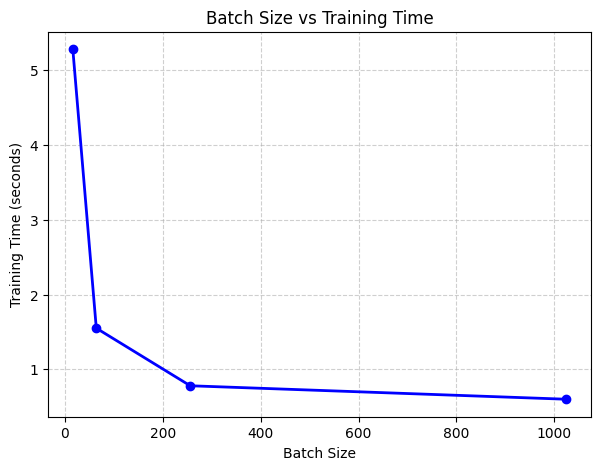

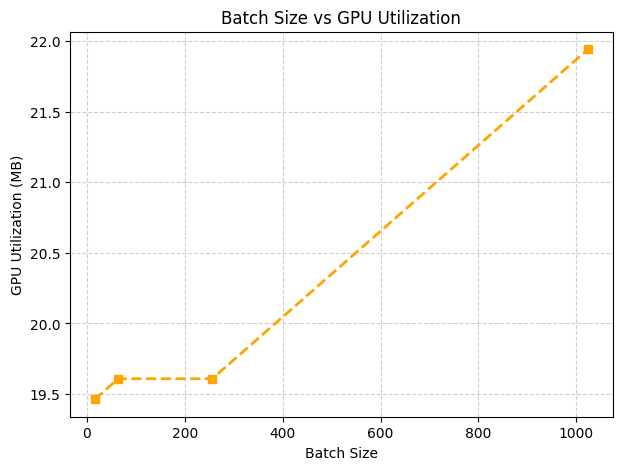

In [21]:
import matplotlib.pyplot as plt

# Data from your experiment
batch_sizes = [16, 64, 256, 1024]
training_times = [5.28, 1.55, 0.78, 0.60]  # seconds
gpu_utils = [20409344, 20561408, 20561408, 23006720]  # bytes

# Convert GPU memory utilization from bytes to MB for readability
gpu_utils_mb = [x / (1024 ** 2) for x in gpu_utils]

# --- Plot 1: Batch Size vs Training Time ---
plt.figure(figsize=(7, 5))
plt.plot(batch_sizes, training_times, 'o-', color='blue', linewidth=2, markersize=6)
plt.title('Batch Size vs Training Time')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- Plot 2: Batch Size vs GPU Utilization ---
plt.figure(figsize=(7, 5))
plt.plot(batch_sizes, gpu_utils_mb, 's--', color='orange', linewidth=2, markersize=6)
plt.title('Batch Size vs GPU Utilization')
plt.xlabel('Batch Size')
plt.ylabel('GPU Utilization (MB)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

SIMPLE 2 LAYER MODEL


In [50]:
import os
import struct
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ---------------------------
# Dataset Class (same as before)
# ---------------------------
class MNIST_IDX_Dataset(Dataset):
    def __init__(self, image_path, label_path):
        self.images = self._read_image_file(image_path)
        self.labels = self._read_label_file(label_path)

    def _read_label_file(self, path):
        with open(path, 'rb') as f:
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic != 2049:
                raise ValueError(f"Invalid magic number {magic} in label file {path}")
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return torch.tensor(labels, dtype=torch.long)

    def _read_image_file(self, path):
        with open(path, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            if magic != 2051:
                raise ValueError(f"Invalid magic number {magic} in image file {path}")
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            images = image_data.reshape(num_images, 1, rows, cols)
            images_float = images.astype(np.float32) / 255.0
            return torch.tensor(images_float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ---------------------------
# Simple 2-Layer CNN Model
# ---------------------------
class TwoLayerCNN(nn.Module):
    """
    A simplified CNN with only 2 trainable layers:
    - 1 Convolutional layer
    - 1 Fully connected layer
    """
    def __init__(self):
        super(TwoLayerCNN, self).__init__()
        # 1st Layer: Conv + ReLU + MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)  # 28x28 -> 14x14

        # 2nd Layer: Fully connected (input: 8 * 14 * 14, output: 10)
        self.fc = nn.Linear(8 * 14 * 14, 10)

    def forward(self, x):
        out = self.pool(self.relu(self.conv1(x)))   # Layer 1
        out = out.view(-1, 8 * 14 * 14)
        out = self.fc(out)                          # Layer 2
        return out


# ---------------------------
# Training & Evaluation (same hyperparams)
# ---------------------------
def main():
    DATA_DIR = '/content/mnist_data'
    IMAGES_PATH = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    LABELS_PATH = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')

    if not all(os.path.exists(p) for p in [IMAGES_PATH, LABELS_PATH]):
        print("Error: MNIST data files not found.")
        return

    LEARNING_RATE = 0.001
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")

    full_dataset = MNIST_IDX_Dataset(IMAGES_PATH, LABELS_PATH)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = TwoLayerCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Starting training...")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        epoch_start = time.time()
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_time = time.time() - epoch_start
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed in {epoch_time:.2f}s")

    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f} seconds")
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated()} bytes")
    !nvidia-smi


    # Evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on {total} test images: {accuracy:.2f}%")

if __name__ == '__main__':
    main()



Using device: cuda
Starting training...
Epoch [1/5] completed in 0.24s
Epoch [2/5] completed in 0.25s
Epoch [3/5] completed in 0.24s
Epoch [4/5] completed in 0.24s
Epoch [5/5] completed in 0.25s

Total training time: 1.22 seconds
Allocated GPU memory: 17501696 bytes
Sun Oct 12 08:33:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00

MEDIUM 5 LAYER MODEL

In [56]:
import os
import struct
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# ---------------------------
# Dataset Class (same as before)
# ---------------------------
class MNIST_IDX_Dataset(Dataset):
    def __init__(self, image_path, label_path):
        self.images = self._read_image_file(image_path)
        self.labels = self._read_label_file(label_path)

    def _read_label_file(self, path):
        with open(path, 'rb') as f:
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic != 2049:
                raise ValueError(f"Invalid magic number {magic} in label file {path}")
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return torch.tensor(labels, dtype=torch.long)

    def _read_image_file(self, path):
        with open(path, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            if magic != 2051:
                raise ValueError(f"Invalid magic number {magic} in image file {path}")
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            images = image_data.reshape(num_images, 1, rows, cols)
            images_float = images.astype(np.float32) / 255.0
            return torch.tensor(images_float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# ---------------------------
# Five-Layer CNN Model
# ---------------------------
class FiveLayerCNN(nn.Module):
    """
    5 trainable layers:
      - Conv1 (trainable)
      - Conv2 (trainable)
      - Conv3 (trainable)
      - FC1   (trainable)
      - FC2   (trainable, output)
    Non-trainable: ReLUs and MaxPool for downsampling.
    """
    def __init__(self):
        super(FiveLayerCNN, self).__init__()
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # trainable layer 1
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)  # 28x28 -> 14x14

        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # trainable layer 2

        # Conv block 3 (no pooling after this one; keep spatial 7x7)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # trainable layer 3

        # Fully connected layers
        # After pool -> pool: spatial becomes 7x7, channels = 64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # trainable layer 4
        self.fc2 = nn.Linear(128, 10)          # trainable layer 5 (output)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # conv1 -> relu -> pool (28->14)
        x = self.pool(self.relu(self.conv2(x)))   # conv2 -> relu -> pool (14->7)
        x = self.relu(self.conv3(x))              # conv3 -> relu (7->7)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# ---------------------------
# Training & Evaluation (same hyperparams)
# ---------------------------
def main():
    DATA_DIR = '/content/mnist_data'
    IMAGES_PATH = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    LABELS_PATH = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')

    if not all(os.path.exists(p) for p in [IMAGES_PATH, LABELS_PATH]):
        print("Error: MNIST data files not found.")
        return

    LEARNING_RATE = 0.001
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {DEVICE}")

    # Load dataset & split
    full_dataset = MNIST_IDX_Dataset(IMAGES_PATH, LABELS_PATH)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model, loss, optimizer (same optimizer & lr as before)
    model = FiveLayerCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("Starting training...")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        print(f"--- Time for Epoch {epoch+1}: {epoch_end_time - epoch_start_time:.2f} seconds ---")

    end_time = time.time()
    training_duration = end_time - start_time
    print("Training finished.")
    print(f"Total training time: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes).")
    print(f"Allocated memory on gpu device: {torch.cuda.memory_allocated()}")
    !nvidia-smi

    # Evaluation
    print("\nEvaluating model...")
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')


if __name__ == '__main__':
    main()


Using device: cuda
Starting training...
Epoch [1/5], Step [100/125], Loss: 0.5142
--- Time for Epoch 1: 0.36 seconds ---
Epoch [2/5], Step [100/125], Loss: 0.1888
--- Time for Epoch 2: 0.34 seconds ---
Epoch [3/5], Step [100/125], Loss: 0.1234
--- Time for Epoch 3: 0.33 seconds ---
Epoch [4/5], Step [100/125], Loss: 0.0813
--- Time for Epoch 4: 0.35 seconds ---
Epoch [5/5], Step [100/125], Loss: 0.0395
--- Time for Epoch 5: 0.34 seconds ---
Training finished.
Total training time: 1.71 seconds (0.03 minutes).
Allocated memory on gpu device: 24069632
Sun Oct 12 08:38:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |  

MULTI THREADED DATA LOADING ON 9 LAYERED CNN MODEL

In [5]:
import os
import struct
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class MNIST_IDX_Dataset(Dataset):
    """
    Custom PyTorch Dataset class to handle MNIST data in the IDX file format.
    """
    def __init__(self, image_path, label_path):
        """
        Args:
            image_path (str): Path to the .idx3-ubyte image file.
            label_path (str): Path to the .idx1-ubyte label file.
        """
        self.images = self._read_image_file(image_path)
        self.labels = self._read_label_file(label_path)

    def _read_label_file(self, path):
        """Reads a .idx1-ubyte file and returns a tensor of labels."""
        with open(path, 'rb') as f:
            # Read header information
            # >: big-endian, I: unsigned int
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic != 2049:
                raise ValueError(f"Invalid magic number {magic} in label file {path}")

            # Read label data
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return torch.tensor(labels, dtype=torch.long)

    def _read_image_file(self, path):
        """Reads a .idx3-ubyte file and returns a tensor of images."""
        with open(path, 'rb') as f:
            # Read header information
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            if magic != 2051:
                raise ValueError(f"Invalid magic number {magic} in image file {path}")

            # Read image data
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            # Reshape into (num_images, 1, height, width) for CNN
            images = image_data.reshape(num_images, 1, rows, cols)
            # Normalize pixel values to [0, 1]
            images_float = images.astype(np.float32) / 255.0
            return torch.tensor(images_float)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Returns one sample of data: image and its label."""
        return self.images[idx], self.labels[idx]

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network for MNIST classification.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 28x28 -> 14x14

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 14x14 -> 7x7

        # Fully connected layers
        # The input features are 32 channels * 7 * 7 image size
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 10 output classes for digits 0-9

    def forward(self, x):
        """Defines the forward pass of the network."""
        # Conv block 1
        out = self.pool1(self.relu1(self.conv1(x)))
        # Conv block 2
        out = self.pool2(self.relu2(self.conv2(out)))
        # Flatten the output for the fully connected layer
        out = out.view(-1, 32 * 7 * 7)
        # FC layers
        out = self.relu3(self.fc1(out))
        out = self.fc2(out)
        return out

def main():
    """Main function to train and evaluate the network."""
    # --- 1. Configuration ---
    DATA_DIR = '/content/mnist_data'
    IMAGES_PATH = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    LABELS_PATH = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')

    # Check if data files exist. Note: Training requires both images and labels.
    if not all(os.path.exists(p) for p in [IMAGES_PATH, LABELS_PATH]):
        print(f"Error: MNIST data files not found in '{DATA_DIR}'.")
        print("This script requires both the image and label file to run.")
        print("Please ensure the following files are in the directory:")
        print(" - t10k-images.idx3-ubyte")
        print(" - t10k-labels.idx1-ubyte")
        print("You can get them from http://yann.lecun.com/exdb/mnist/")
        return

    # Hyperparameters
    LEARNING_RATE = 0.001
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    #DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    DEVICE = torch.device('cuda')
    print(f"Using device: {DEVICE}")

    # --- 2. Load Data and Split ---
    print("Loading dataset...")
    full_dataset = MNIST_IDX_Dataset(IMAGES_PATH, LABELS_PATH)

    # Split the dataset into training and testing sets (e.g., 80% train, 20% test)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    print(f"Dataset loaded and split into {len(train_dataset)} training samples and {len(test_dataset)} testing samples.")

    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers = 8, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers= 8, shuffle=False)
    print("Data loaders created.")

    # --- 3. Initialize Model, Loss, and Optimizer ---
    model = SimpleCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- 4. Training Loop ---
    print("Starting training...")
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        data_loading_time = 0.0
        epoch_start_time = time.time()
        model.train()             # Set model to training mode

        end_of_last_iter = time.time()



        for i, (images, labels) in enumerate(train_loader):
            # Move data to the configured device
            data_loading_time += time.time() - end_of_last_iter


            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
                print(f"Data Loading Time: {data_loading_time:.2f} seconds")

            end_of_last_iter = time.time()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"--- Time for Epoch {epoch+1}: {epoch_duration:.2f} seconds ---")


    end_time = time.time()
    training_duration = end_time - start_time
    print("Training finished.")

    print(f"Total training time: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes).")
    print(f"Allocated memory on gpu device: {torch.cuda.memory_allocated()}")
    !nvidia-smi

    # --- 5. Evaluation ---
    print("\nEvaluating model...")
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')


if __name__ == '__main__':
    main()




Using device: cuda
Loading dataset...
Dataset loaded and split into 8000 training samples and 2000 testing samples.
Data loaders created.
Starting training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/5], Step [100/125], Loss: 0.2647
Data Loading Time: 0.29 seconds
--- Time for Epoch 1: 0.72 seconds ---
Epoch [2/5], Step [100/125], Loss: 0.1396
Data Loading Time: 0.27 seconds
--- Time for Epoch 2: 0.68 seconds ---
Epoch [3/5], Step [100/125], Loss: 0.0910
Data Loading Time: 0.26 seconds
--- Time for Epoch 3: 0.67 seconds ---
Epoch [4/5], Step [100/125], Loss: 0.0484
Data Loading Time: 0.28 seconds
--- Time for Epoch 4: 0.76 seconds ---
Epoch [5/5], Step [100/125], Loss: 0.0348
Data Loading Time: 0.27 seconds
--- Time for Epoch 5: 0.74 seconds ---
Training finished.
Total training time: 3.56 seconds (0.06 minutes).
Allocated memory on gpu device: 20561408
Sun Oct 12 09:14:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name      

AMP MODEL TRAINING

In [6]:
import os
import struct
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class MNIST_IDX_Dataset(Dataset):
    """
    Custom PyTorch Dataset class to handle MNIST data in the IDX file format.
    """
    def __init__(self, image_path, label_path):
        self.images = self._read_image_file(image_path)
        self.labels = self._read_label_file(label_path)

    def _read_label_file(self, path):
        with open(path, 'rb') as f:
            magic, num_items = struct.unpack('>II', f.read(8))
            if magic != 2049:
                raise ValueError(f"Invalid magic number {magic} in label file {path}")
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return torch.tensor(labels, dtype=torch.long)

    def _read_image_file(self, path):
        with open(path, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            if magic != 2051:
                raise ValueError(f"Invalid magic number {magic} in image file {path}")
            image_data = np.frombuffer(f.read(), dtype=np.uint8)
            images = image_data.reshape(num_images, 1, rows, cols)
            images_float = images.astype(np.float32) / 255.0
            return torch.tensor(images_float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network for MNIST classification.
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 28x28 -> 14x14

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 14x14 -> 7x7

        # Fully connected layers
        # The input features are 32 channels * 7 * 7 image size
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 10 output classes for digits 0-9

    def forward(self, x):
        # Conv block 1
        out = self.pool1(self.relu1(self.conv1(x)))
        # Conv block 2
        out = self.pool2(self.relu2(self.conv2(out)))
        # Flatten the output for the fully connected layer
        out = out.view(-1, 32 * 7 * 7)
        # FC layers
        out = self.relu3(self.fc1(out))
        out = self.fc2(out)
        return out

def main():
    """Main function to train and evaluate the network using AMP (float16 where safe)."""
    # --- 1. Configuration ---
    DATA_DIR = '/content/mnist_data'
    IMAGES_PATH = os.path.join(DATA_DIR, 't10k-images.idx3-ubyte')
    LABELS_PATH = os.path.join(DATA_DIR, 't10k-labels.idx1-ubyte')

    if not all(os.path.exists(p) for p in [IMAGES_PATH, LABELS_PATH]):
        print(f"Error: MNIST data files not found in '{DATA_DIR}'.")
        print("This script requires both the image and label file to run.")
        print("Please ensure the following files are in the directory:")
        print(" - t10k-images.idx3-ubyte")
        print(" - t10k-labels.idx1-ubyte")
        print("You can get them from http://yann.lecun.com/exdb/mnist/")
        return

    # Hyperparameters
    LEARNING_RATE = 0.001
    BATCH_SIZE = 64
    NUM_EPOCHS = 5
    DEVICE = torch.device('cuda')  # AMP requires CUDA
    print(f"Using device: {DEVICE}")

    # --- 2. Load Data and Split ---
    print("Loading dataset...")
    full_dataset = MNIST_IDX_Dataset(IMAGES_PATH, LABELS_PATH)

    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

    print(f"Dataset loaded and split into {len(train_dataset)} training samples and {len(test_dataset)} testing samples.")

    # You can enable multi-threaded loading if desired:
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    print("Data loaders created.")

    # --- 3. Initialize Model, Loss, Optimizer, and AMP scaler ---
    model = SimpleCNN().to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # AMP: automatic mixed precision
    scaler = torch.cuda.amp.GradScaler()

    # --- 4. Training Loop (with AMP) ---
    print("Starting training (with AMP)...")
    start_time = time.time()
    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # Move data to device (use non_blocking=True when pin_memory=True)
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)

            # Forward and backward with mixed precision
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():               # runs forward in mixed precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Scales the loss, calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()
            # Unscales gradients and calls or skips optimizer.step()
            scaler.step(optimizer)
            # Updates the scale for next iteration
            scaler.update()

            if (i + 1) % 100 == 0:
                # To display loss as float (loss is a tensor), use .item()
                print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"--- Time for Epoch {epoch+1}: {epoch_duration:.2f} seconds ---")

    end_time = time.time()
    training_duration = end_time - start_time
    print("Training finished.")
    print(f"Total training time: {training_duration:.2f} seconds ({training_duration/60:.2f} minutes).")
    print(f"Allocated memory on gpu device: {torch.cuda.memory_allocated()}")
    # In Colab you can still run !nvidia-smi in a separate cell as needed

    # --- 5. Evaluation (use autocast for faster inference if desired) ---
    print("\nEvaluating model...")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')

if __name__ == '__main__':
    main()


Using device: cuda
Loading dataset...
Dataset loaded and split into 8000 training samples and 2000 testing samples.
Data loaders created.
Starting training (with AMP)...


/tmp/ipython-input-1734596148.py:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1734596148.py:134: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():               # runs forward in mixed precision


Epoch [1/5], Step [100/125], Loss: 0.4587
--- Time for Epoch 1: 0.71 seconds ---
Epoch [2/5], Step [100/125], Loss: 0.3202
--- Time for Epoch 2: 0.42 seconds ---
Epoch [3/5], Step [100/125], Loss: 0.2981
--- Time for Epoch 3: 0.44 seconds ---
Epoch [4/5], Step [100/125], Loss: 0.0814
--- Time for Epoch 4: 0.49 seconds ---
Epoch [5/5], Step [100/125], Loss: 0.1261
--- Time for Epoch 5: 0.50 seconds ---
Training finished.
Total training time: 2.57 seconds (0.04 minutes).
Allocated memory on gpu device: 20561408

Evaluating model...
Accuracy of the network on the 2000 test images: 96.15 %


/tmp/ipython-input-1734596148.py:169: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
